In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
data = pd.read_csv('/Users/justinlum/Downloads/NUS/AY2425S1/BT4012/Project file/Fraudulent_E-Commerce_Transaction_Data.csv')

**Data Overview**

In [4]:
data.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472952 entries, 0 to 1472951
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Transaction ID      1472952 non-null  object 
 1   Customer ID         1472952 non-null  object 
 2   Transaction Amount  1472952 non-null  float64
 3   Transaction Date    1472952 non-null  object 
 4   Payment Method      1472952 non-null  object 
 5   Product Category    1472952 non-null  object 
 6   Quantity            1472952 non-null  int64  
 7   Customer Age        1472952 non-null  int64  
 8   Customer Location   1472952 non-null  object 
 9   Device Used         1472952 non-null  object 
 10  IP Address          1472952 non-null  object 
 11  Shipping Address    1472952 non-null  object 
 12  Billing Address     1472952 non-null  object 
 13  Is Fraudulent       1472952 non-null  int64  
 14  Account Age Days    1472952 non-null  int64  
 15  Transaction Hou

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Transaction Amount,1472952.0,226.768309,270.395099,10.0,68.61,151.76,296.05,12701.75
Quantity,1472952.0,3.000230,1.414736,1.0,2.00,3.00,4.00,5.00
Customer Age,1472952.0,34.512081,10.003134,-16.0,28.00,35.00,41.00,86.00
Is Fraudulent,1472952.0,0.050129,0.218212,0.0,0.00,0.00,0.00,1.00
Account Age Days,1472952.0,179.646398,106.864223,1.0,86.00,179.00,272.00,365.00
Transaction Hour,1472952.0,11.286964,6.975995,0.0,5.00,11.00,17.00,23.00


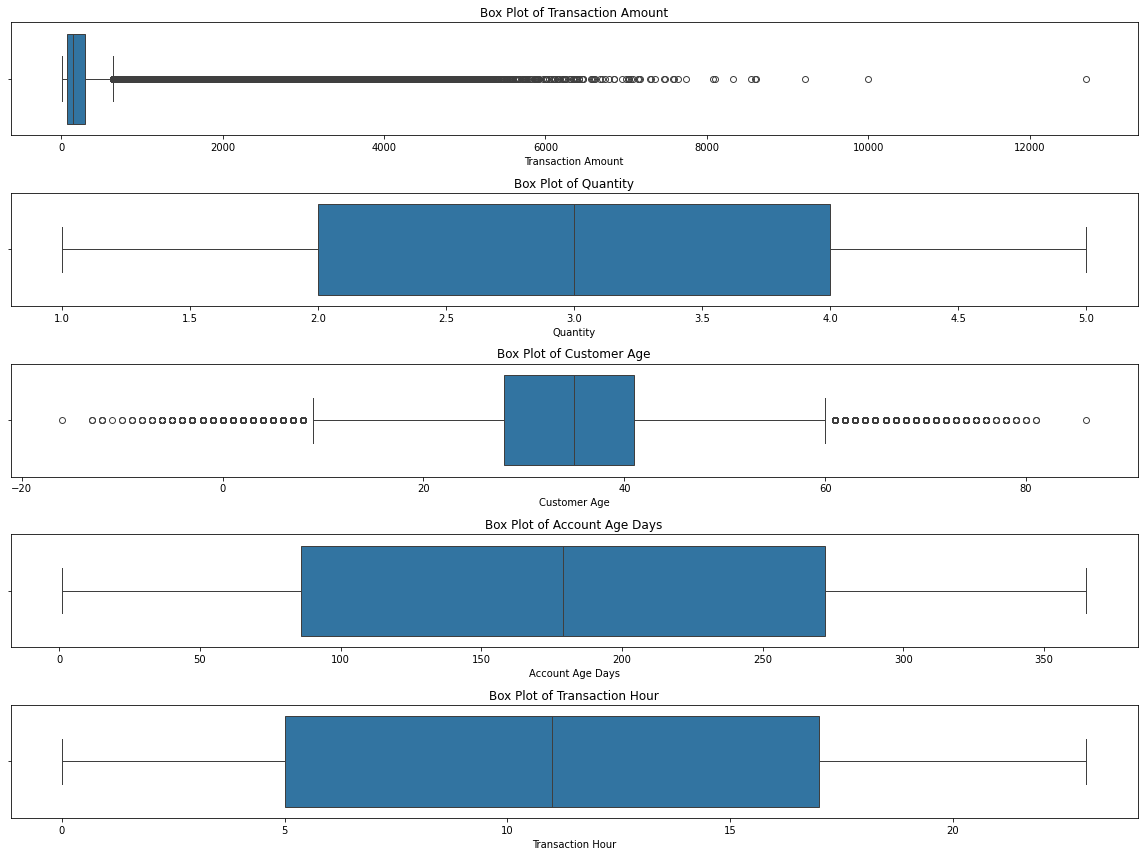

In [7]:
features = ['Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour']

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x=feature, data=data, ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()


## **Data Cleaning and Feature Engineering**

In [8]:
# Clean customer age
mean_age = data['Customer Age'].mean()
data.loc[data['Customer Age'] < 12, 'Customer Age'] = mean_age

/var/folders/8f/059mmz814bq3z_xwhvm3qknr0000gn/T/ipykernel_47429/311068984.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '34.5120811811926' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['Customer Age'] < 12, 'Customer Age'] = mean_age


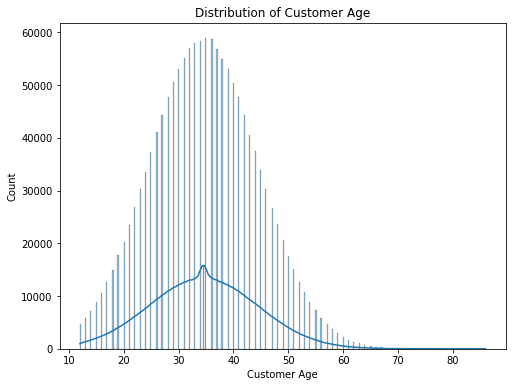

In [9]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Customer Age'], kde=True)
plt.xlabel('Customer Age')
plt.ylabel('Count')
plt.title('Distribution of Customer Age')
plt.show()

In [10]:
# Create age groups

def age_groups(x):
    if x < 20:
        return 0
    elif 20 <= x <= 29:
        return 1
    elif 30 <= x <= 39:
        return 2
    elif 40 <= x <= 49:
        return 3
    elif 50 <= x <= 59:
        return 4
    else:
        return 5
    
data['Age Group'] = data['Customer Age'].apply(age_groups)

In [11]:
# Clean transaction date
data["Transaction Date"] = pd.to_datetime(data["Transaction Date"])
data['Transaction Day'] = data["Transaction Date"].dt.day.astype(int)
data["Transaction Day of Week"] = data["Transaction Date"].dt.day_of_week.astype(int)
data["Transaction Month"] = data["Transaction Date"].dt.month.astype(int)


In [12]:
# Create time of day groups

def time_of_day_groups(x):
    if x < 6:
        return 0
    elif 6 <= x <= 11:
        return 1
    elif 12 <= x <= 17:
        return 2
    else:
        return 3

data['Time of Day'] = data['Transaction Hour'].apply(age_groups)
    

In [13]:
# Add address matching feature
data['isAddressMatched'] = (data["Shipping Address"] == data["Billing Address"]).astype(int)

In [14]:
# See unique locations
len(data['Customer Location'].unique())

# Use target encoding
import category_encoders as ce

target_encoder = ce.TargetEncoder(cols=['Customer Location'])
data['custLocEncoded'] = target_encoder.fit_transform(data['Customer Location'], data['Is Fraudulent'])

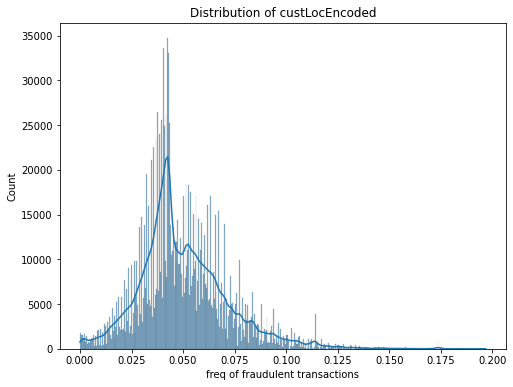

In [15]:
plt.figure(figsize=(8, 6))
sns.histplot(data['custLocEncoded'], kde=True)
plt.xlabel('freq of fraudulent transactions')
plt.ylabel('Count')
plt.title('Distribution of custLocEncoded')
plt.show()

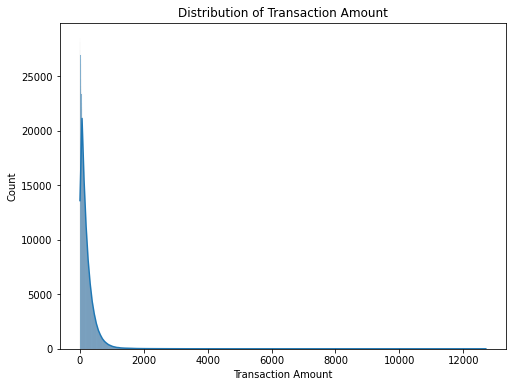

In [16]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Transaction Amount'], kde=True)
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Distribution of Transaction Amount')
plt.show()

In [17]:
# Rescale transaction amount
data['Transaction Amount Rescaled'] = data['Transaction Amount'].apply(lambda x: math.log10(x))
data['Transaction Amount Rescaled'] = StandardScaler().fit_transform(data[['Transaction Amount Rescaled']])

In [18]:
data['Price per product'] = data['Transaction Amount'] / data['Quantity']

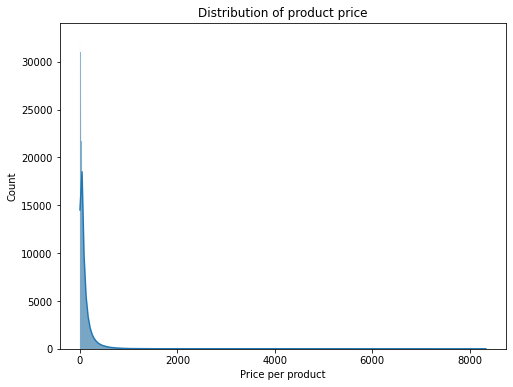

In [19]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Price per product'], kde=True)
plt.xlabel('Price per product')
plt.ylabel('Count')
plt.title('Distribution of product price')
plt.show()

In [20]:
# Rescale product price
data['Product Price Rescaled'] = data['Price per product'].apply(lambda x: math.log10(x))
data['Product Price Rescaled'] = StandardScaler().fit_transform(data[['Product Price Rescaled']])

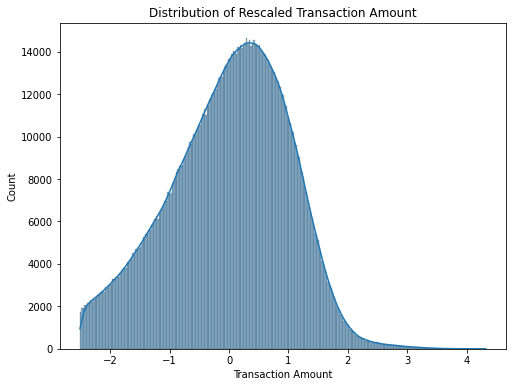

In [21]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Transaction Amount Rescaled'], kde=True)
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Distribution of Rescaled Transaction Amount')
plt.show()

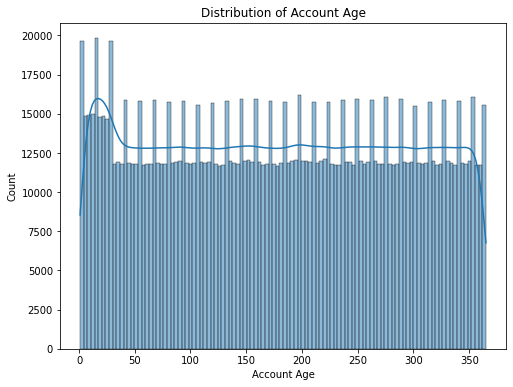

In [22]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Account Age Days'], kde=True)
plt.xlabel('Account Age')
plt.ylabel('Count')
plt.title('Distribution of Account Age')
plt.show()

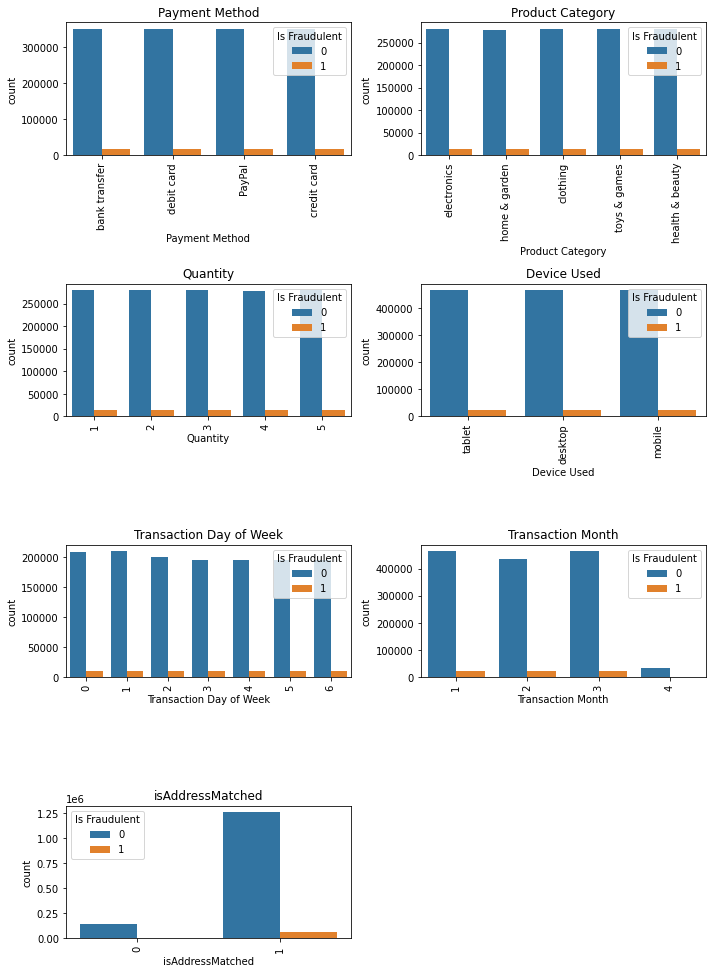

In [23]:
column = ['Payment Method', 'Product Category', 
       'Quantity', 'Device Used','Transaction Day of Week', 
       'Transaction Month','isAddressMatched']

plt.figure(figsize=(10,35))
plot_num = 1
for col in column:
    plt.subplot(10,2,plot_num)
    sns.countplot(data=data, x=col, hue="Is Fraudulent")
    plt.xticks(rotation=90)
    plt.title(col)
    plt.tight_layout()
    plot_num += 1

In [24]:
# Rescale account age
data['Account Age Rescaled'] = data['Account Age Days'].apply(lambda x: math.log10(x))
data['Account Age Rescaled'] = StandardScaler().fit_transform(data[['Account Age Rescaled']])

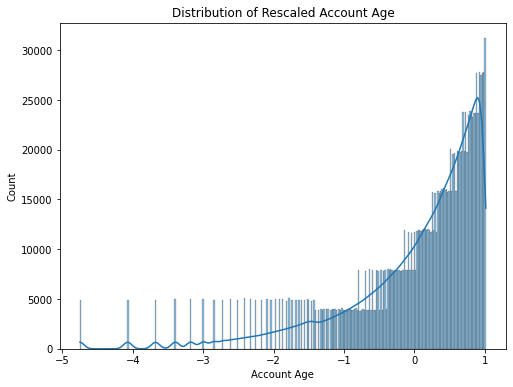

In [25]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Account Age Rescaled'], kde=True)
plt.xlabel('Account Age')
plt.ylabel('Count')
plt.title('Distribution of Rescaled Account Age')
plt.show()

In [26]:
# Use one-hot encoding
from sklearn.compose import ColumnTransformer

encoder = OneHotEncoder(sparse_output=False)
features = ['Time of Day', 'Age Group', 'Payment Method', 'Product Category', 'Device Used', 'Transaction Month', 'Transaction Day of Week']
encoded_features = encoder.fit_transform(data[features])
encoded_data = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(features))
encoded_data.head()

final_data = pd.concat([data, encoded_data], axis=1 )



In [27]:
final_data.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour,Age Group,Transaction Day,Transaction Day of Week,Transaction Month,Time of Day,isAddressMatched,custLocEncoded,Transaction Amount Rescaled,Price per product,Product Price Rescaled,Account Age Rescaled,Time of Day_0,Time of Day_1,Age Group_0,Age Group_1,Age Group_2,Age Group_3,Age Group_4,Age Group_5,Payment Method_PayPal,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_clothing,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_desktop,Device Used_mobile,Device Used_tablet,Transaction Month_1,Transaction Month_2,Transaction Month_3,Transaction Month_4,Transaction Day of Week_0,Transaction Day of Week_1,Transaction Day of Week_2,Transaction Day of Week_3,Transaction Day of Week_4,Transaction Day of Week_5,Transaction Day of Week_6
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17.0,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5,0,20,1,2,0,1,0.053691,-0.827832,58.090,0.076596,-1.426831,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40.0,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8,3,25,6,2,0,1,0.055016,0.991816,194.980,1.093000,-0.571788,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22.0,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3,1,18,0,3,0,1,0.054795,-0.027683,67.095,0.197564,-0.702204,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31.0,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20,2,16,5,3,1,1,0.039005,0.471207,45.234,-0.133370,-0.040856,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51.0,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5,4,15,0,1,0,1,0.041237,-0.122386,60.765,0.114385,0.195804,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
final_data.shape

(1472952, 58)

**EDA**

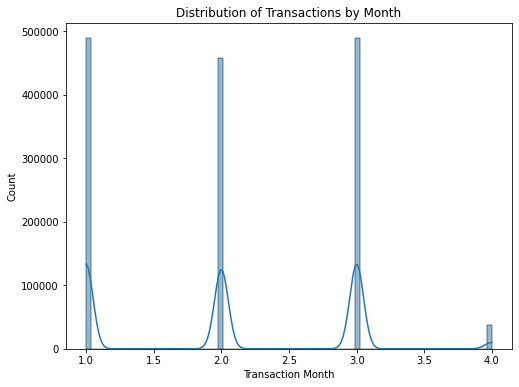

In [29]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Transaction Month'], kde=True)
plt.xlabel('Transaction Month')
plt.ylabel('Count')
plt.title('Distribution of Transactions by Month')
plt.show()

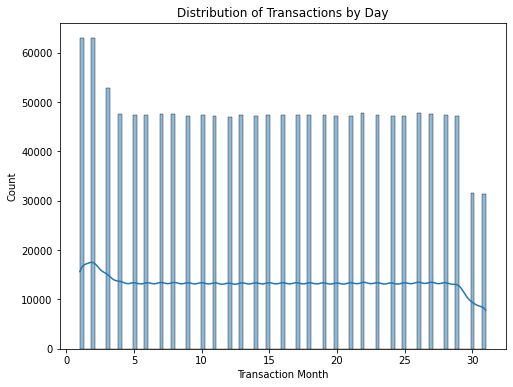

In [30]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Transaction Day'], kde=True)
plt.xlabel('Transaction Month')
plt.ylabel('Count')
plt.title('Distribution of Transactions by Day')
plt.show()

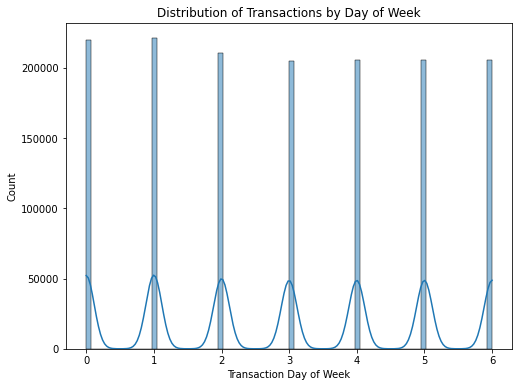

In [31]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Transaction Day of Week'], kde=True)
plt.xlabel('Transaction Day of Week')
plt.ylabel('Count')
plt.title('Distribution of Transactions by Day of Week')
plt.show()

In [32]:
final_data.drop(columns=[
                    'Transaction ID',
                    'Customer ID',
                    'Transaction Date',
                    'Payment Method',
                    'Product Category',
                    'Customer Location',
                    'Device Used',
                    'Shipping Address',
                    'Billing Address', 
                    'IP Address',
                    'Transaction Amount',
                    'Account Age Days',
                    'Price per product',
                        ], inplace=True)

In [33]:
final_data.head()

,Quantity,Customer Age,Is Fraudulent,Transaction Hour,Age Group,Transaction Day,Transaction Day of Week,Transaction Month,Time of Day,isAddressMatched,custLocEncoded,Transaction Amount Rescaled,Product Price Rescaled,Account Age Rescaled,Time of Day_0,Time of Day_1,Age Group_0,Age Group_1,Age Group_2,Age Group_3,Age Group_4,Age Group_5,Payment Method_PayPal,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_clothing,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_desktop,Device Used_mobile,Device Used_tablet,Transaction Month_1,Transaction Month_2,Transaction Month_3,Transaction Month_4,Transaction Day of Week_0,Transaction Day of Week_1,Transaction Day of Week_2,Transaction Day of Week_3,Transaction Day of Week_4,Transaction Day of Week_5,Transaction Day of Week_6
0,1,17.0,0,5,0,20,1,2,0,1,0.053691,-0.827832,0.076596,-1.426831,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,40.0,0,8,3,25,6,2,0,1,0.055016,0.991816,1.093000,-0.571788,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,22.0,0,3,1,18,0,3,0,1,0.054795,-0.027683,0.197564,-0.702204,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,31.0,0,20,2,16,5,3,1,1,0.039005,0.471207,-0.133370,-0.040856,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2,51.0,0,5,4,15,0,1,0,1,0.041237,-0.122386,0.114385,0.195804,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Handling imbalanced data
Observing the ratio of fraudulent to non-fraudulent transactions, there is a huge imbalance (only 5% fraudulent transactions). This could cause problems for some of our models, as they may tend to favor the majority class and result in a poor performance in identifying fraud.

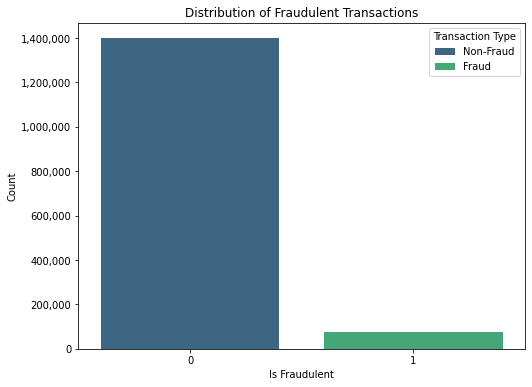

In [34]:
import matplotlib.ticker as mticker

plt.figure(figsize=(8, 6))
sns.countplot(x='Is Fraudulent', hue='Is Fraudulent', data=final_data, palette='viridis', dodge=False, legend=False)
plt.xlabel('Is Fraudulent')
plt.ylabel('Count')
plt.title('Distribution of Fraudulent Transactions')
plt.legend(title='Transaction Type', labels=['Non-Fraud', 'Fraud'], loc='upper right')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

In [35]:
fraud_nonfraud_ratio = final_data['Is Fraudulent'].value_counts(normalize=True)

fraud_nonfraud_ratio

Is Fraudulent
0    0.949871
1    0.050129
Name: proportion, dtype: float64

In [36]:
X = final_data.copy().drop(columns=['Is Fraudulent'])
y = final_data['Is Fraudulent']

## **Train and test split without oversampling**

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## **Train and Test split with oversampling**

We also conduct oversampling, and compare the models' performance with and without oversampling

In [38]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)
print(X_resampled.shape,y_resampled.shape)

(2798228, 44) (2798228,)


In [39]:
y_resampled.value_counts()

Is Fraudulent
0    1399114
1    1399114
Name: count, dtype: int64

In [40]:
X_train_oversampled, X_test_oversampled, y_train_oversampled, y_test_oversampled = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

## **Random Forest**

In [42]:
# model without oversampling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

model = RandomForestClassifier(
    n_estimators=50,       
    max_depth=5,           # Limit tree depth
    max_features=0.8,      # Reduce features for splits
    bootstrap=True,        # Enable bootstrapping
    random_state=42,       # Reproducibility
    n_jobs=-1,             # Use all CPU cores
    min_samples_split=10,  # Larger splits to reduce depth
    min_samples_leaf=5     # Fewer leaves for faster runtime
)
model.fit(X_train, y_train)

# predict the labels
y_pred = model.predict(X_test)

y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    279823
           1       0.76      0.22      0.34     14768

    accuracy                           0.96    294591
   macro avg       0.86      0.61      0.66    294591
weighted avg       0.95      0.96      0.95    294591

Confusion Matrix:
 [[278789   1034]
 [ 11534   3234]]
Accuracy Score: 0.9573374610901215
ROC AUC Score: 0.8630840497234847


In [43]:
# model with oversampling

model_oversampled = RandomForestClassifier(
    n_estimators=50,       
    max_depth=5,           # Limit tree depth
    max_features=0.8,      # Reduce features for splits
    bootstrap=True,        # Enable bootstrapping
    random_state=42,       # Reproducibility
    n_jobs=-1,             # Use all CPU cores
    min_samples_split=10,  # Larger splits to reduce depth
    min_samples_leaf=5     # Fewer leaves for faster runtime
)
model_oversampled.fit(X_train_oversampled, y_train_oversampled)

# predict the labels
y_pred_oversampled = model_oversampled.predict(X_test_oversampled)

y_pred_proba_oversampled = model_oversampled.predict_proba(X_test_oversampled)[:, 1]

print("Classification Report:\n", classification_report(y_test_oversampled, y_pred_oversampled))
print("Confusion Matrix:\n", confusion_matrix(y_test_oversampled, y_pred_oversampled))
print("Accuracy Score:", accuracy_score(y_test_oversampled, y_pred_oversampled))
print("ROC AUC Score:", roc_auc_score(y_test_oversampled, y_pred_proba_oversampled))

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80    279823
           1       0.82      0.75      0.78    279823

    accuracy                           0.79    559646
   macro avg       0.79      0.79      0.79    559646
weighted avg       0.79      0.79      0.79    559646

Confusion Matrix:
 [[232911  46912]
 [ 69857 209966]]
Accuracy Score: 0.7913520332495899
ROC AUC Score: 0.8871268415463937


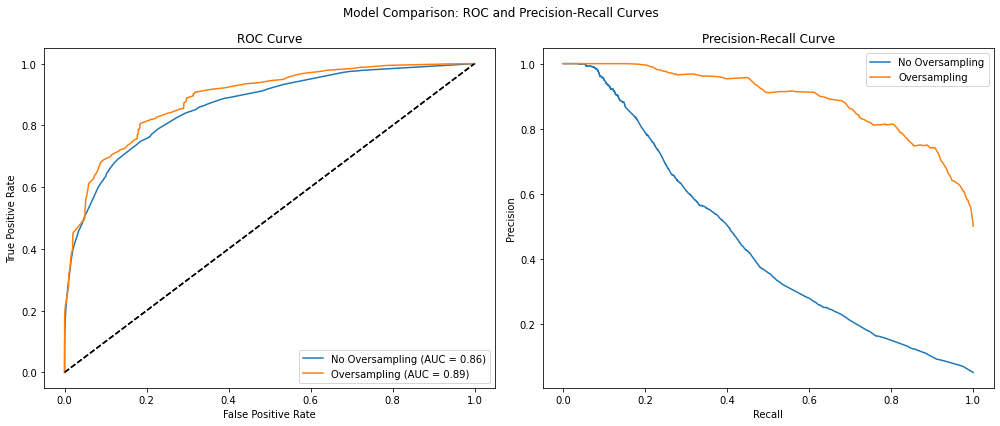

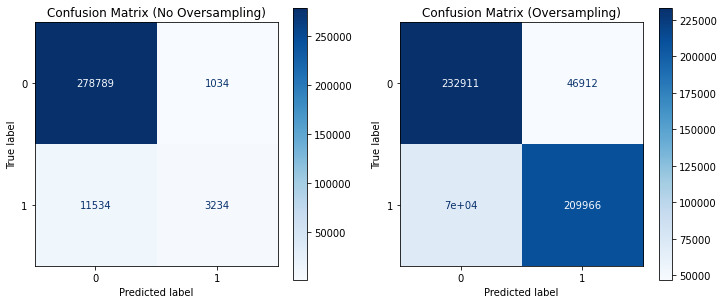

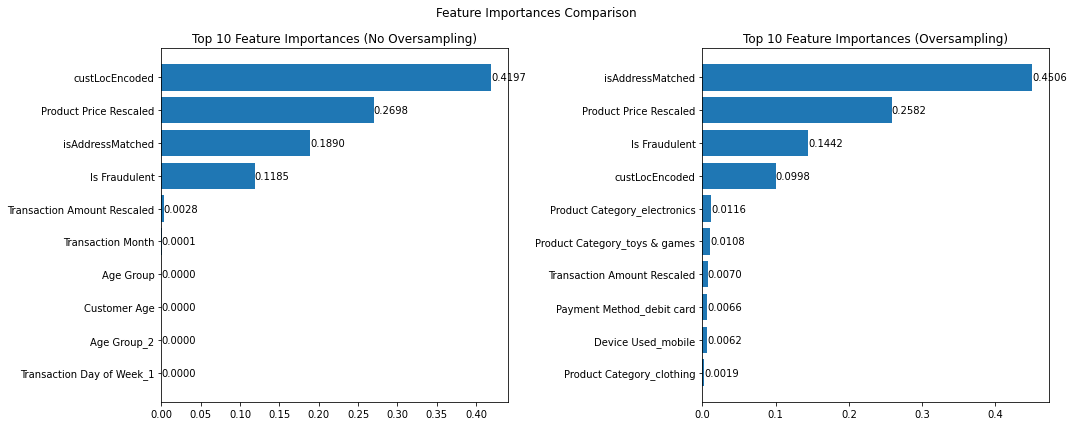

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, ConfusionMatrixDisplay, roc_auc_score

# Define ROC Curve plotting function
def plot_roc_curve(ax, y_test, y_pred_proba, label):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    ax.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")
    ax.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")

# Define Precision-Recall Curve plotting function
def plot_precision_recall_curve(ax, y_test, y_pred_proba, label):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax.plot(recall, precision, label=label)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve")

# Create a figure with side-by-side subplots for ROC and Precision-Recall curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC Curves
plot_roc_curve(axes[0], y_test, y_pred_proba, "No Oversampling")
plot_roc_curve(axes[0], y_test_oversampled, y_pred_proba_oversampled, "Oversampling")
axes[0].legend()

# Plot Precision-Recall Curves
plot_precision_recall_curve(axes[1], y_test, y_pred_proba, "No Oversampling")
plot_precision_recall_curve(axes[1], y_test_oversampled, y_pred_proba_oversampled, "Oversampling")
axes[1].legend()

plt.suptitle("Model Comparison: ROC and Precision-Recall Curves")
plt.tight_layout()
plt.show()

# Confusion Matrix Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# No Oversampling
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[0], cmap="Blues")
axes[0].set_title("Confusion Matrix (No Oversampling)")

# Oversampling
ConfusionMatrixDisplay.from_predictions(y_test_oversampled, y_pred_oversampled, ax=axes[1], cmap="Blues")
axes[1].set_title("Confusion Matrix (Oversampling)")

plt.show()

#PLOT FEATURE IMPORTANCE

# Feature names from final_data
feature_names = final_data.columns

# Feature importance for No Oversampling
feature_importance_no_os = model.feature_importances_
sorted_idx_no_os = np.argsort(feature_importance_no_os)[::-1]  # Sort indices by importance
top_features_no_os = [(feature_names[i], feature_importance_no_os[i]) for i in sorted_idx_no_os[:10]]

# Feature importance for Oversampling
feature_importance_os = model_oversampled.feature_importances_
sorted_idx_os = np.argsort(feature_importance_os)[::-1]  # Sort indices by importance
top_features_os = [(feature_names[i], feature_importance_os[i]) for i in sorted_idx_os[:10]]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Top 10 Feature Importances for No Oversampling
axes[0].barh(
    [name for name, _ in top_features_no_os],
    [score for _, score in top_features_no_os]
)
axes[0].set_title("Top 10 Feature Importances (No Oversampling)")
axes[0].invert_yaxis()  # To have the highest importance on top

# Annotate the bars with importance scores
for i, (name, score) in enumerate(top_features_no_os):
    axes[0].text(score, i, f"{score:.4f}", va='center')

# Top 10 Feature Importances for Oversampling
axes[1].barh(
    [name for name, _ in top_features_os],
    [score for _, score in top_features_os]
)
axes[1].set_title("Top 10 Feature Importances (Oversampling)")
axes[1].invert_yaxis()

# Annotate the bars with importance scores
for i, (name, score) in enumerate(top_features_os):
    axes[1].text(score, i, f"{score:.4f}", va='center')

# Overall Title and Layout
plt.suptitle("Feature Importances Comparison")
plt.tight_layout()
plt.show()



Explanation:

The recall for the minority class improved from 0.22 (No Oversampling) to 0.75 (Oversampling). This means the model is correctly identifying 75% of the minority class instances instead of just 22%.

ROC AUC score increased from 0.86 to 0.89, indicating that the model is better at distinguishing between classes overall. Theres an improved balance in sensitivity (recall) and specificity.